In [1]:
import warnings
warnings.filterwarnings('ignore')

import os
from datetime import datetime, timedelta
import pandas as pd
import swifter
import numpy as np
import requests
from matplotlib import pyplot as plt
import seaborn as sns
from tqdm.autonotebook import tqdm
import keras
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows', 1000)

tqdm.pandas()

In [2]:
train_base_dir = '/data/training_files'
test_base_dir = '/data/test_files'

In [71]:
def process_df(df):
    columns = ['x', 'y', 'client timestamp']
    columns_2 = ['veloc', 'theta', 'client timestamp']
    df_filtered = df[df['client timestamp'].diff() > 0]
    resolution_x, resolution_y = parse_standard_resolution(df.x.max(), df.y.max())
    df_filtered['x'] = df_filtered['x']/resolution_x
    df_filtered['y'] = df_filtered['y']/resolution_y
    diff = df_filtered[columns].diff()
    diff.rename(columns={'x': 'dx', 'y': 'dy', 'client timestamp': 'dt'}, inplace=True)
    diff['dx/dt'] = diff['dt'].where(diff['dt']==0, diff['dx']/diff['dt'])
    diff['dy/dt'] = diff['dt'].where(diff['dt']==0, diff['dy']/diff['dt'])
    diff['veloc'] = (diff['dx/dt'] * diff['dx/dt'] + diff['dy/dt'] * diff['dy/dt']) ** (1/2)
    diff['theta'] = np.where(np.isnan(diff['dx']), 0, np.arctan(diff['dy']/diff['dx']))
    tmp = pd.concat([df_filtered, diff], axis=1)
    diff_2 = tmp[columns_2].diff()
    diff_2.rename(columns={'veloc': 'dveloc', 'theta': 'dtheta','client timestamp': 'dt'}, inplace=True)
    diff_2['accel'] = diff_2['dt'].where(diff_2['dt']==0, diff_2['dveloc'].abs() / diff_2['dt'])
    diff_2['dtheta/dt'] = diff_2['dt'].where(diff_2['dt']==0, diff_2['dtheta'].abs() / diff_2['dt'])
    diff_2.drop('dt', axis=1, inplace=True)
    result = pd.concat([tmp, diff_2], axis=1)
    result = result[result.veloc.notna() & result.accel.notna()].reset_index()
    return result


def parse_standard_resolution(x_max, y_max):
    """ Parses an appropriate screen resolution

        Parameters:
            x_max (int): maximum x coordinate
            y_max (int): maximum y coordinate

        Returns:
            x_std (int), y_std(int): standard screen resolution
    """
    x_standard = [320, 360, 480, 720, 768, 1024, 1280, 1360, 1366, 1440, 1600, 1680, 1920]
    y_standard = [480, 568, 640, 720, 768, 800, 900, 1024, 1050, 1080, 1200, 1280]

    # Parsing x coordinate
    x_pos = 0
    while x_standard[x_pos] < x_max and x_pos < len(x_standard) - 1:
        x_pos += 1

    # Parsing y coordinate
    y_pos = 0
    while y_standard[y_pos] < y_max and y_pos < len(y_standard) - 1:
        y_pos += 1

    if x_max > x_standard[x_pos]:
        x_standard[x_pos] = x_max

    if y_max > y_standard[y_pos]:
        y_standard[y_pos] = y_max

    return x_standard[x_pos], y_standard[y_pos]


In [72]:
data = {}
base = os.listdir(os.getcwd() + train_base_dir)
path = os.getcwd() + train_base_dir
for user in tqdm(base, total=len(base)):
    _path = path + '/' + user
    data[user] = {}
    for session in os.listdir(_path):
        filename = _path + '/' + session
        _df = pd.read_csv(filename, engine='pyarrow')
        data[user][session] = _df        

  0%|          | 0/10 [00:00<?, ?it/s]

In [73]:
data_test = {}
base_test = os.listdir(os.getcwd() + test_base_dir)
path_test = os.getcwd() + test_base_dir
for user in tqdm(base, total=len(base_test)):
    _path = path + '/' + user
    data_test[user] = {}
    for session in os.listdir(_path):
        filename = _path + '/' + session
        _df = pd.read_csv(filename, engine='pyarrow')
        data_test[user][session] = _df        

  0%|          | 0/10 [00:00<?, ?it/s]

In [74]:
profiles_processed_test = {}
with pd.option_context('mode.use_inf_as_na', True):
    for user in data_test:
        profiles_processed_test[user] = {}
        for profile in data_test[user]:
            profiles_processed_test[user][profile] = process_df(data_test[user][profile])

In [75]:
profiles_processed = {}
with pd.option_context('mode.use_inf_as_na', True):
    for user in data:
        profiles_processed[user] = {}
        for profile in data[user]:
            profiles_processed[user][profile] = process_df(data[user][profile])

In [76]:
_dfs = []
for user, sessions in profiles_processed_test.items():
    for session, session_data in sessions.items():
        df = pd.DataFrame(session_data)
        df.insert(0, 'user', user)
        df.insert(1, 'profile', session)
        _dfs.append(df)

result_df_test = pd.concat(_dfs, ignore_index=True)


In [77]:
_dfs = []
for user, sessions in profiles_processed.items():
    for session, session_data in sessions.items():
        df = pd.DataFrame(session_data)
        df.insert(0, 'user', user)
        df.insert(1, 'profile', session)
        _dfs.append(df)

result_df = pd.concat(_dfs, ignore_index=True)

In [78]:
result_df

,user,profile,index,record timestamp,client timestamp,button,state,x,y,dx,dy,dt,dx/dt,dy/dt,veloc,theta,dveloc,dtheta,accel,dtheta/dt
0,user9,session_0335985747,5,0.102,0.047,NoButton,Move,0.006516,0.006531,0.000015,-0.000076,0.015,0.001017,-0.005086,0.005187,-1.373401,0.004233,0.197396,0.282225,13.159704
1,user9,session_0335985747,8,0.103,0.063,NoButton,Move,0.006516,0.006424,0.000000,-0.000107,0.016,0.000000,-0.006676,0.006676,-1.570796,0.001489,-0.197396,0.093047,12.337222
2,user9,session_0335985747,9,0.103,0.078,NoButton,Move,0.006500,0.006409,-0.000015,-0.000015,0.015,-0.001017,-0.001017,0.001439,0.785398,-0.005237,2.356194,0.349146,157.079634
3,user9,session_0335985747,11,0.103,0.094,NoButton,Move,0.006455,0.006378,-0.000046,-0.000031,0.016,-0.002861,-0.001907,0.003439,0.588003,0.002000,-0.197396,0.124996,12.337222
4,user9,session_0335985747,13,0.103,0.110,NoButton,Move,0.006363,0.006363,-0.000092,-0.000015,0.016,-0.005722,-0.000954,0.005801,0.165149,0.002362,-0.422854,0.147656,26.428371
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908517,user29,session_5396497934,13700,6782.323,6782.362,NoButton,Move,0.003998,0.000809,-0.000473,-0.000092,0.109,-0.004340,-0.000840,0.004420,0.191184,0.002090,-0.808274,0.019177,7.415361
1908518,user29,session_5396497934,13701,6782.532,6782.565,NoButton,Move,0.003952,0.000809,-0.000046,0.000000,0.203,-0.000226,0.000000,0.000226,-0.000000,-0.004195,-0.191184,0.020664,0.941795
1908519,user29,session_5396497934,13703,6782.628,6782.674,NoButton,Drag,0.003952,0.000793,0.000000,-0.000015,0.109,0.000000,-0.000140,0.000140,-1.570796,-0.000086,-1.570796,0.000785,14.410975
1908520,user29,session_5396497934,13705,6783.516,6783.532,Left,Pressed,0.003952,0.000793,0.000000,0.000000,0.858,0.000000,0.000000,0.000000,NaN,-0.000140,NaN,0.000163,NaN


In [8]:
result_df_test.shape

(1908522, 17)

In [9]:
labels = pd.read_csv('data/public_labels.csv')

In [10]:
labels

,filename,is_illegal
0,session_0003960194,1
1,session_0005840196,0
2,session_0025450757,0
3,session_0029922803,0
4,session_0064281061,1
5,session_0071280153,0
6,session_0080153528,1
7,session_0083463746,0
8,session_0101735014,0
9,session_0111356050,1


In [13]:
def get_time(df):
    timevec = np.array([])
    for i in range(len(df) - 1):
        time = df.iloc[i]['client timestamp']
        timevec = np.append(timevec, time)
    return timevec

def angle_of_movement(df):
    totalanglemovement = np.array([])
    for i in range(len(df) - 1):
        angle_movement = np.arctan2(df.iloc[i + 1]['y'] - df.iloc[i]['y'], df.iloc[i + 1]['x'] - df.iloc[i]['x'])
        totalanglemovement = np.append(totalanglemovement, angle_movement * 180 / np.pi)
    return totalanglemovement

# Curvature

def curvature(df):
    def diff_theta(x1, x2, y1, y2):
        deltax = x2 - x1
        deltay = y2 - y1
        if deltay == 0 and deltax == 0:
            distance = 1
            theta = (0 + 2 * np.pi)
            diff_thetavalue = np.divide(theta, distance)
        elif deltax == 0:
            s = (y2 - y1) ** 2
            distance = np.sqrt(s)
            theta = (90 + 2 * np.pi)
            diff_thetavalue = np.divide(theta, distance)
        else:
            s = (x2 - x1) ** 2 + (y2 - y1) ** 2
            distance = np.sqrt(s)
            theta = np.arctan(deltay / deltax) + 2 * np.pi
            diff_thetavalue = np.divide(theta, distance)
        return diff_thetavalue

    curvaturevec = np.array([])
    for i in range(len(df) - 1):
        a = df.iloc[i + 1]['x']
        b = df.iloc[i]['x']
        c = df.iloc[i + 1]['y']
        d = df.iloc[i]['y']
        curvatureval = diff_theta(a, b, c, d)
        curvaturevec = np.append(curvaturevec, curvatureval)
    return curvaturevec

# This varies between 0 and 1 where 1 is
# equal to the shortest path between the initial point and final point
# It may be noted that generally humans have poor efficiency and bots have high efficiency and hence
# this may be very useful in differentiating between the two from mouse movements
def efficiency(df):
    max_x = df.iloc[len(df) - 1]['x']
    max_y = df.iloc[len(df) - 1]['y']
    init_x = df.iloc[0]['x']
    init_y = df.iloc[0]['y']
    sqrx = np.square(max_x - init_x)
    sqry = np.square(max_y - init_y)
    best_dist = np.sqrt(sqrx + sqry)
    sum_of_distances = 0
    for j in range(len(df) - 1):
        sum_of_distances += np.sqrt(np.square(df.iloc[j + 1]['x'] - df.iloc[j]['x'])
                                    + np.square(df.iloc[j + 1]['y'] - df.iloc[j]['y']))

    final_efficiency = np.divide(best_dist, sum_of_distances)
    return final_efficiency


# Regularity is higher for bots as they might mostly move straight to the target
def regularity(df):
    def meandistance():
        tempx = 0
        tempy = 0
        for l in range(len(df)):
            tempx += df.iloc[l]['x']
            tempy += df.iloc[l]['y']
        mean_x = np.divide(tempx, len(df))
        mean_y = np.divide(tempy, len(df))
        meanboth = np.array([mean_x, mean_y])
        return meanboth

    def distancefromcentre(meanxy, currentxy):
        return np.sqrt(np.square(currentxy[0] - meanxy[0]) + np.square(currentxy[1] - meanxy[1]))
    tempdistance = 0
    
    distanceofcentre = meandistance()
    for u in range(len(df)):
        current_point = np.array([df.iloc[u]['x'], df.iloc[u]['y']])
        tempdistance += distancefromcentre(distanceofcentre, current_point)
    meanofthedistances = np.divide(tempdistance, len(df))
    tempdeviation = 0
    for t in range(len(df)):
        current_point = np.array([df.iloc[u]['x'], df.iloc[u]['y']])
        tempdeviation += np.square(distancefromcentre(distanceofcentre, current_point) -
                                   meanofthedistances)
    std_deviation_square = np.divide(tempdeviation, len(df))
    std_deviation = np.sqrt(std_deviation_square)
    finalregularityofcompletepath = np.divide(meanofthedistances, (meanofthedistances + std_deviation))
    return finalregularityofcompletepath

# Jerk
def num_of_pauses(df):
    def pauseslist(df):
        pauses = np.array([])
        for h in range(len(df) - 1):
            timediff = df.iloc[h + 1]['client timestamp'] - df.iloc[h]['client timestamp']
            if timediff > 0.1:  #HCI for a pause i.e. 0.1
                pauses = np.append(pauses, timediff)
            else:
                pauses = np.append(pauses, 0)
        return pauses

    list_of_pauses = pauseslist(df)
    countpauses = 0
    for h in range(len(list_of_pauses)):
        if list_of_pauses[h] != 0:
            countpauses += 1
    return countpauses

def total_change_in_angle(df):
    finalangle = np.arctan2(df.iloc[len(df) - 1]['y'], df.iloc[len(df) - 1]['x'])
    firstangle = np.arctan2(df.iloc[0]['y'], df.iloc[0]['x'])
    return (finalangle - firstangle) * 180 / np.pi

In [20]:
metrics_all = []
for user in tqdm(profiles_processed, total=len(profiles_processed)):
    for profile in profiles_processed[user]:
        metrics = {
            'user': user,
            'profile': profile,
            'veloc_mean': profiles_processed[user][profile].veloc.mean(),
            'veloc_std': profiles_processed[user][profile].veloc.std(),
            'accel_mean': profiles_processed[user][profile].accel.mean(),
            'accel_std': profiles_processed[user][profile].accel.std(),
            'x_mean': profiles_processed[user][profile].x.mean(),
            'x_std': profiles_processed[user][profile].x.std(),
            'y_mean': profiles_processed[user][profile].y.mean(),
            'y_std': profiles_processed[user][profile].y.std(),
            'angle_of_movement': total_change_in_angle(profiles_processed[user][profile]),
            'curvature': curvature(profiles_processed[user][profile]),
            'num_of_pauses': num_of_pauses(profiles_processed[user][profile]),
            'efficiency': efficiency(profiles_processed[user][profile]),
            'regularity': regularity(profiles_processed[user][profile]),
            'total_change_in_angle': total_change_in_angle(profiles_processed[user][profile])
        }
        metrics_all.append(metrics)
df_metrics = pd.DataFrame(metrics_all)

  0%|          | 0/10 [00:00<?, ?it/s]

In [21]:
df_metrics

,user,profile,veloc_mean,veloc_std,accel_mean,accel_std,x_mean,x_std,y_mean,y_std,angle_of_movement,curvature,num_of_pauses,efficiency,regularity,total_change_in_angle
0,user9,session_0335985747,0.007843,0.122172,0.257412,5.853675,0.005374,0.014337,0.004480,0.014108,7.070440,"[901416.9355865694, 327559.8750212358, 124891.66436041068, 69473.62577043836, 34587.45782433866, 41176.85491060156, 20726.237004390816, 14320.503784085598, 11900.418203266338, 16658.295422820545, 31967.08501240518, 98868.57188846916, 6309918.549106037, 6309918.549106037, 39397.61893304151, 28497.73828554943, 1051653.0915176629, 3154959.2745530186, 3154959.2745530186, 3154959.2745530186, 90948.78587737671, 60470.923494689305, 43612.75005538508, 27074.620785242598, 26331.942632865426, 38887.85462906672, 163779.9375106179, 132067.4425016322, 132067.44250163133, 108298.48314097089, 163779.9375106179, 216596.96628194017, 327559.8750212358, 163779.9375106179, 163779.9375106179, 108298.48314096972, 108298.48314097046, 132067.4425016329, 132067.4425016329, 216596.96628194177, 216596.96628194177, 216596.9662819356, 216596.96628194177, 163779.9375106179, 216596.96628194177, 163779.9375106179, 216596.96628194177, 163779.93751061553, 2103306.1830353457, 216596.96628194177, 3154959.274552974, 216596.96628194177, 3154959.2745530186, 3154959.2745530186, 216596.96628193944, 216596.96628194177, 216596.96628194177, 3154959.2745530186, 216596.96628193944, 3154959.2745530186, 216596.96628194017, 3154959.2745530186, 216596.96628193944, 3154959.2745530186, 6309918.549106037, 216596.96628194177, 6309918.549106037, 3154959.274552974, 63102.86300857058, 151700.02043706278, 2103306.1830353257, 3154959.2745530186, 6.283185307179586, 6.283185307179586, 327559.87502123043, 109186.62500707858, 76691.58468818234, 32133.850967874547, 31370.632299924186, 40944.98437765432, 156097.85630710487, 3154959.2745530186, 151700.02043706278, 84922.93056106065, 95974.71138244591, 41269.781664397015, 81094.08907068288, 68440.30129621063, 68440.30129621031, 136880.60259242106, 197737.1437769359, 163779.9375106179, 136880.60259242126, 98868.57188846855, 83291.47711410292, 81094.08907068279, 163779.9375106179, 163779.93751061655, 163779.9375106179, 6309918.5491058575, ...]",2246,0.000153,0.627898,7.070440
1,user9,session_8764610836,0.458078,1.083678,13.026968,69.101690,0.232992,0.166136,0.403216,0.244023,-24.358388,"[201.30603696309674, 207.64553208990978, 1654.224514396028, 3308.449028792056, 989.6584899533544, 1366.0281042500956, 1223.1541981134956, 1097.4114873608683, 1129.1399370304946, 1709.0264035528278, 1001.1954323433997, 959.8089473618929, 474.72955654245834, 389.1375648006702, 392.73852180120747, 449.02319836639526, 476.15710116188546, 470.99409193605305, 696.026251287273, 1506.8387867808435, 2732.056208500191, 4272.566008882134, 8545.132017763945, 4272.566008882134, 1506.8387867808435, 2194.8229747217365, 2732.056208500169, 4272.566008882134, 2067.3692381989927, 4272.566008882134, 4272.566008882053, 3308.449028792056, 6.283185307179586, 6.283185307179586, 6.283185307179586, 6.283185307179586, 69323.89342116956, 432.5081613421111, 266.4285547499672, 230.63957674783717, 5776.9911184307575, 11553.982236861591, 699.3813998381416, 2643.2387751642254, 69323.89342116956, 2643.2387751642354, 11553.982236861591, 11553.982236861591, 11553.982236861439, 23107.964473723183, 9903.413345881365, 7702.654824574361, 13864.77868423391, 23107.964473722877, 23107.964473723183, 346.6301361404058, 494.5187997501255, 577.5237000484245, 864.3779650953038, 34661.94671058478, 69323.89342116956, 69323.89342116678, 577.5237000484283, 865.0163226842221, 1730.0326453684108, 1654.224514396028, 978.1547842861391, 910.6854028333946, 1366.0281042500956, 1517.725060535579, 1654.224514396028, 2194.8229747217365, 1506.8387867808435, 1506.8387867808342, 1424.1886696273689, 2136.283004441067, 1068.1415022205283, 4272.566008882134, 4272.566008882134, 4272.566008882134, 8545.132017764268, 1366.0281042500899, 1506.8387867808435, 219

In [22]:
df_metrics['curvature_mean'] = df_metrics['curvature'].progress_apply(lambda x: np.array(x).mean())

  0%|          | 0/65 [00:00<?, ?it/s]

In [23]:
df_metrics['curvature_std'] = df_metrics['curvature'].progress_apply(lambda x: np.array(x).std())

  0%|          | 0/65 [00:00<?, ?it/s]

In [24]:
df_model = df_metrics.drop('curvature', axis=1)

In [25]:
df_model[df_model['user'] == 'user9']

,user,profile,veloc_mean,veloc_std,accel_mean,accel_std,x_mean,x_std,y_mean,y_std,angle_of_movement,num_of_pauses,efficiency,regularity,total_change_in_angle,curvature_mean,curvature_std
0,user9,session_0335985747,0.007843,0.122172,0.257412,5.853675,0.005374,0.014337,0.004480,0.014108,7.070440,2246,0.000153,0.627898,7.070440,622819.147081,1.497418e+06
1,user9,session_8764610836,0.458078,1.083678,13.026968,69.101690,0.232992,0.166136,0.403216,0.244023,-24.358388,2537,0.000867,0.870940,-24.358388,7034.495627,1.584099e+04
2,user9,session_5155383252,0.007405,0.070925,0.227358,3.763834,0.005511,0.012836,0.004769,0.012472,-28.538921,2532,0.000684,0.364619,-28.538921,637639.407308,1.511234e+06
3,user9,session_7285432516,0.457578,1.000180,12.388648,57.319389,0.285021,0.227919,0.460958,0.224716,-12.251822,2947,0.000846,0.901608,-12.251822,7135.677227,1.611920e+04
4,user9,session_4373781904,0.409191,0.892177,11.264582,50.129431,0.310374,0.219730,0.424241,0.200215,-60.059954,2682,0.001732,0.724860,-60.059954,6972.035355,1.616246e+04
5,user9,session_3390119815,0.007266,0.045892,0.225706,2.893223,0.005212,0.008454,0.005211,0.008144,-7.413669,2625,0.000666,0.757358,-7.413669,556594.424987,1.431414e+06
6,user9,session_3879637058,0.475100,1.446472,14.442538,90.093515,0.293005,0.219312,0.429618,0.239120,-8.136041,3495,0.000517,0.765834,-8.136041,7138.663103,1.654786e+04


array([[<AxesSubplot: title={'center': 'veloc_mean'}>,
        <AxesSubplot: title={'center': 'veloc_std'}>,
        <AxesSubplot: title={'center': 'accel_mean'}>,
        <AxesSubplot: title={'center': 'accel_std'}>],
       [<AxesSubplot: title={'center': 'x_mean'}>,
        <AxesSubplot: title={'center': 'x_std'}>,
        <AxesSubplot: title={'center': 'y_mean'}>,
        <AxesSubplot: title={'center': 'y_std'}>],
       [<AxesSubplot: title={'center': 'angle_of_movement'}>,
        <AxesSubplot: title={'center': 'num_of_pauses'}>,
        <AxesSubplot: title={'center': 'efficiency'}>,
        <AxesSubplot: title={'center': 'regularity'}>],
       [<AxesSubplot: title={'center': 'total_change_in_angle'}>,
        <AxesSubplot: title={'center': 'curvature_mean'}>,
        <AxesSubplot: title={'center': 'curvature_std'}>,
        <AxesSubplot: >]], dtype=object)

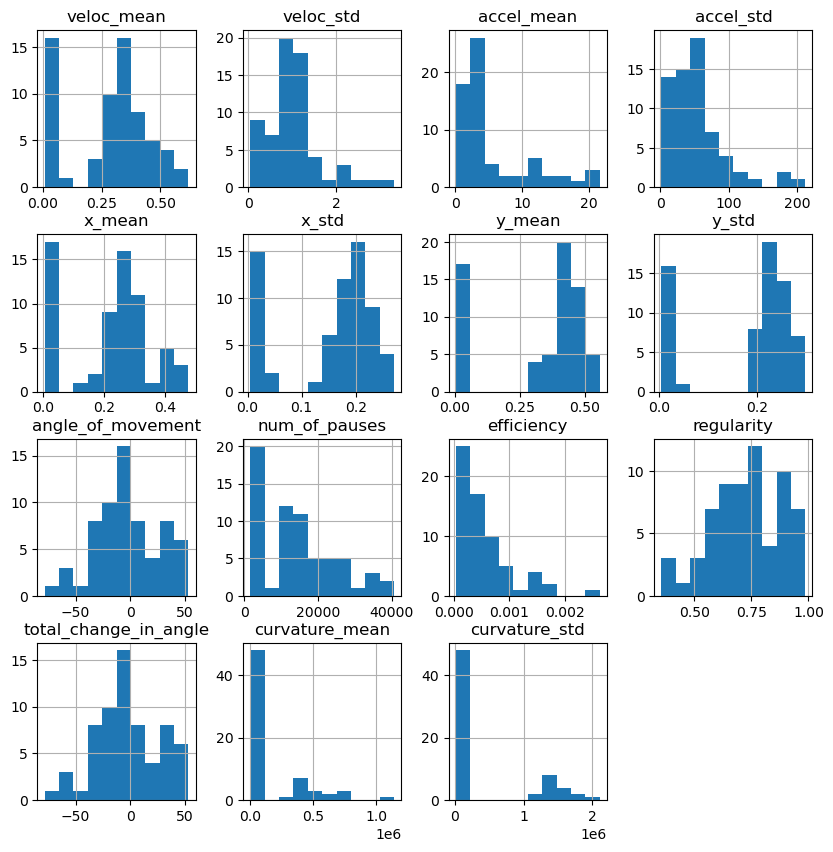

In [314]:
df_model.hist(figsize=(10,10))

In [502]:
df_model.columns

Index(['user', 'profile', 'veloc_mean', 'veloc_std', 'accel_mean', 'accel_std',
       'x_mean', 'x_std', 'y_mean', 'y_std', 'angle_of_movement',
       'num_of_pauses', 'efficiency', 'regularity', 'total_change_in_angle',
       'curvature_mean', 'curvature_std'],
      dtype='object')

<AxesSubplot: >

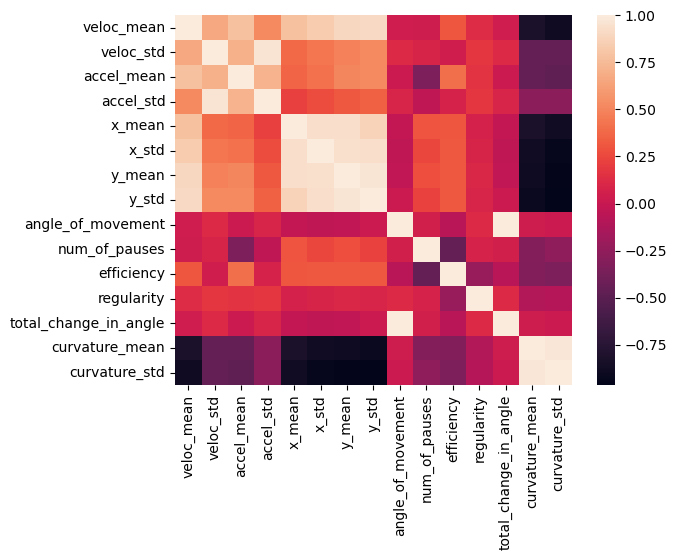

In [312]:
sns.heatmap(df_model.corr())

In [316]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [323]:
features = df_model.drop(columns=['user', 'profile'], axis=1)

In [325]:
scaler=StandardScaler()
features=scaler.fit_transform(features)

In [327]:
pca=PCA(n_components=2)

In [ ]:
pca=PCA(n_components=2)
groups_2d = pca.fit_transform(features)

In [330]:
groups_2d = pca.fit_transform(features)

In [338]:
users = df_model.user

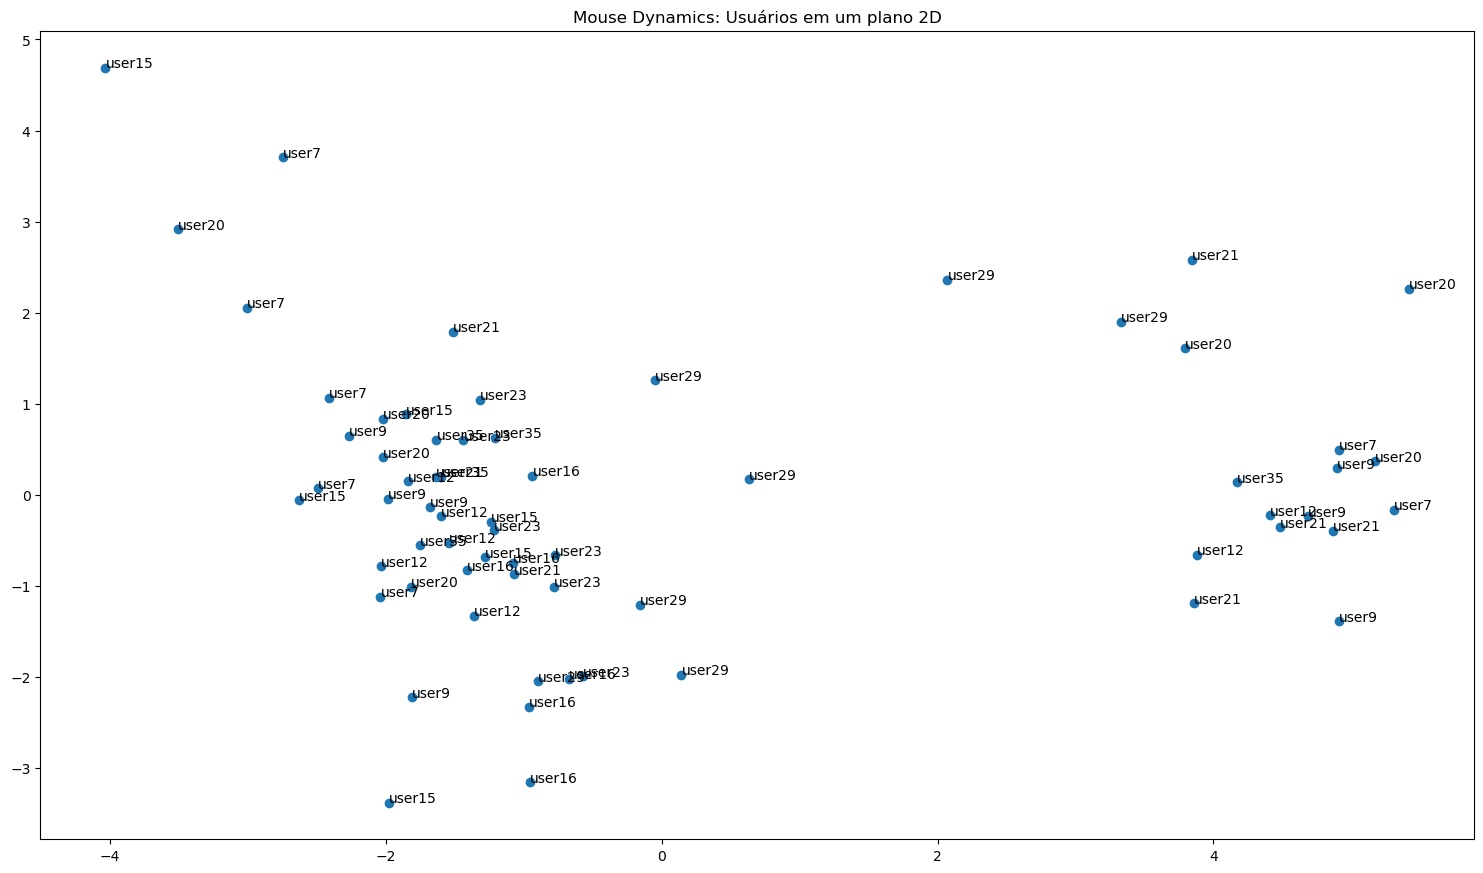

In [344]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.scatter(groups_2d[:,0],groups_2d[:,1])
ax.set_title("Mouse Dynamics: Usuários em um plano 2D")

for i, txt in enumerate(users):
    ax.annotate(txt, (groups_2d[i,0],groups_2d[i,1]))

In [347]:
cluster_vals=range(1,11)
distortions=[]
for c in cluster_vals:
    kmeans=KMeans(n_clusters=c)
    cluster_index=kmeans.fit_predict(features)
    distortions.append(sum(np.min(cdist(features, kmeans.cluster_centers_, 'euclidean'), axis=1))/features.shape[0])


In [348]:
distortions

[3.648781584081185,
 2.642996835534753,
 2.367894775308717,
 2.2408250271066357,
 2.099667211259536,
 2.0028692290646446,
 1.9343489224354546,
 1.8344958567849314,
 1.7807249096673043,
 1.695332452899117]

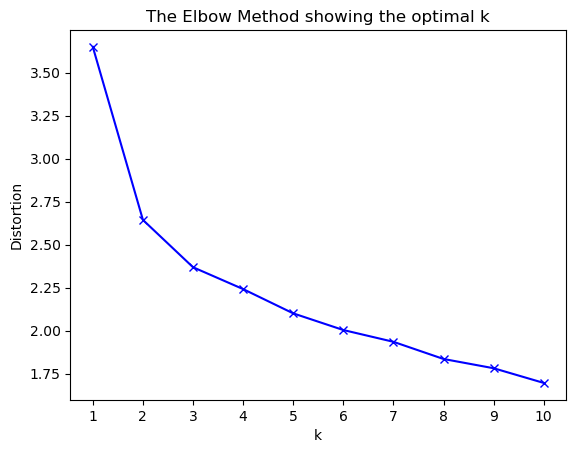

In [349]:
plt.xticks(cluster_vals)
plt.plot(cluster_vals,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [507]:
kmeans=KMeans(n_clusters=3)
cluster_index=kmeans.fit_predict(features)

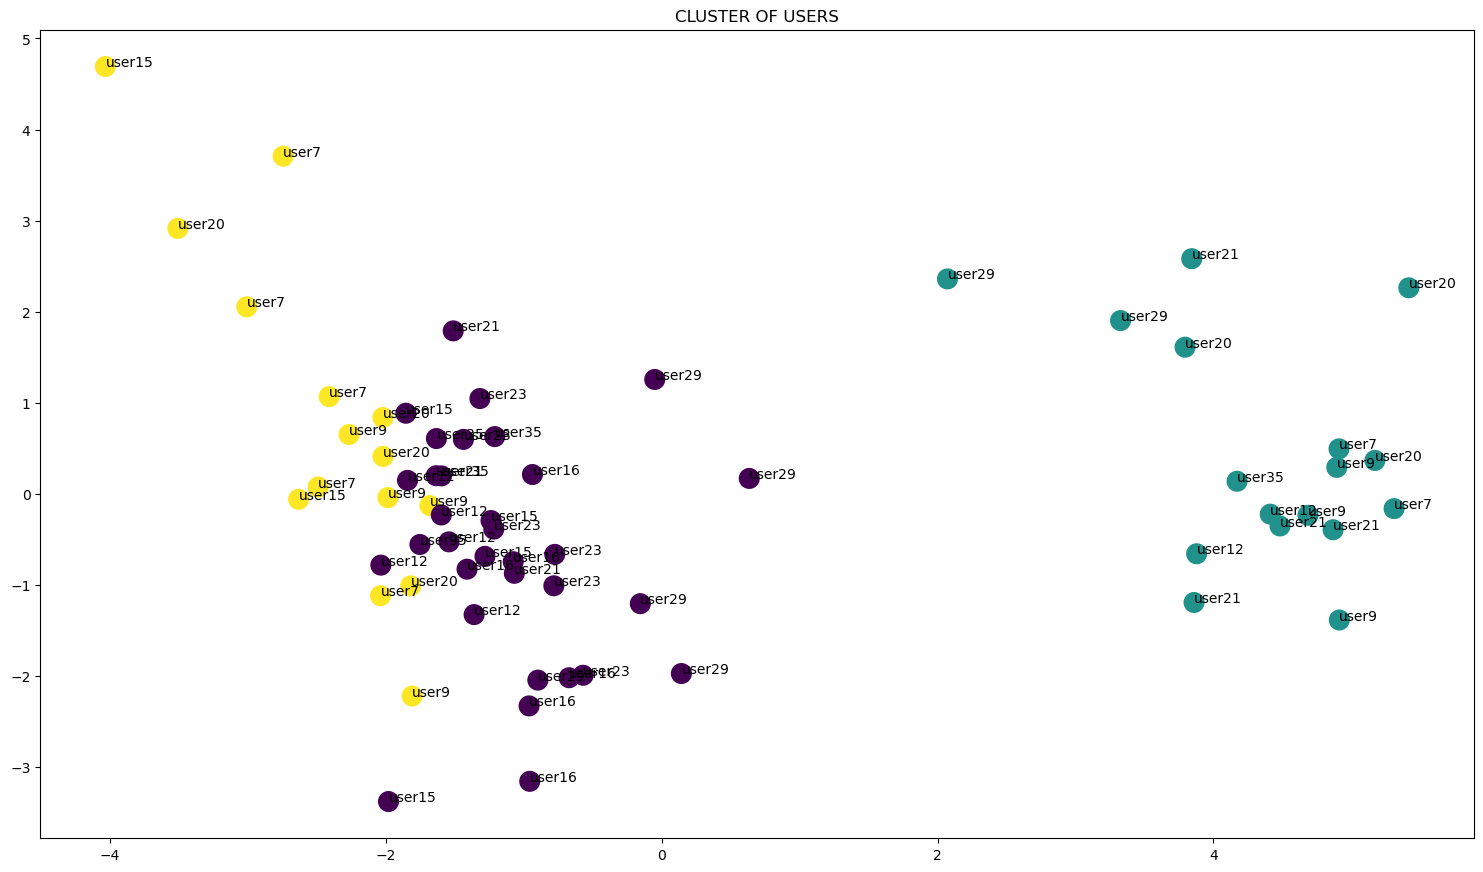

In [508]:
fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.scatter(groups_2d[:,0],groups_2d[:,1],c=cluster_index,marker='o',s=200)
ax.set_title("CLUSTER OF USERS")
for i, txt in enumerate(users):
    ax.annotate(txt, (groups_2d[i,0],groups_2d[i,1]))

In [395]:
df_model.head()

,user,profile,veloc_mean,veloc_std,accel_mean,accel_std,x_mean,x_std,y_mean,y_std,angle_of_movement,num_of_pauses,efficiency,regularity,total_change_in_angle,curvature_mean,curvature_std
0,user9,session_0335985747,0.007843,0.122172,0.257412,5.853675,0.005374,0.014337,0.004480,0.014108,7.070440,2246,0.000153,0.627898,7.070440,622819.147081,1.497418e+06
1,user9,session_8764610836,0.458078,1.083678,13.026968,69.101690,0.232992,0.166136,0.403216,0.244023,-24.358388,2537,0.000867,0.870940,-24.358388,7034.495627,1.584099e+04
2,user9,session_5155383252,0.007405,0.070925,0.227358,3.763834,0.005511,0.012836,0.004769,0.012472,-28.538921,2532,0.000684,0.364619,-28.538921,637639.407308,1.511234e+06
3,user9,session_7285432516,0.457578,1.000180,12.388648,57.319389,0.285021,0.227919,0.460958,0.224716,-12.251822,2947,0.000846,0.901608,-12.251822,7135.677227,1.611920e+04
4,user9,session_4373781904,0.409191,0.892177,11.264582,50.129431,0.310374,0.219730,0.424241,0.200215,-60.059954,2682,0.001732,0.724860,-60.059954,6972.035355,1.616246e+04


In [389]:
df_model.columns

Index(['user', 'profile', 'veloc_mean', 'veloc_std', 'accel_mean', 'accel_std',
       'x_mean', 'x_std', 'y_mean', 'y_std', 'angle_of_movement',
       'num_of_pauses', 'efficiency', 'regularity', 'total_change_in_angle',
       'curvature_mean', 'curvature_std'],
      dtype='object')

In [468]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.metrics import classification_report

In [401]:

data = df_model.copy()
X = data.drop(['user', 'profile'], axis=1) 
y = data['user']

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(optimizer='adam', l s='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_test_scaled, y_test))
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia do modelo: {accuracy}')


Epoch 1/15
2/2 [==============================] - 1s 126ms/step - loss: 2.3802 - accuracy: 0.1154 - val_loss: 2.4239 - val_accuracy: 0.0000e+00
Epoch 2/15
2/2 [==============================] - 0s 27ms/step - loss: 2.3210 - accuracy: 0.1923 - val_loss: 2.4018 - val_accuracy: 0.0000e+00
Epoch 3/15
2/2 [==============================] - 0s 28ms/step - loss: 2.2719 - accuracy: 0.2308 - val_loss: 2.3799 - val_accuracy: 0.0000e+00
Epoch 4/15
2/2 [==============================] - 0s 27ms/step - loss: 2.2300 - accuracy: 0.2692 - val_loss: 2.3606 - val_accuracy: 0.0000e+00
Epoch 5/15
2/2 [==============================] - 0s 27ms/step - loss: 2.1882 - accuracy: 0.2885 - val_loss: 2.3430 - val_accuracy: 0.0000e+00
Epoch 6/15
2/2 [==============================] - 0s 26ms/step - loss: 2.1533 - accuracy: 0.3654 - val_loss: 2.3292 - val_accuracy: 0.0769
Epoch 7/15
2/2 [==============================] - 0s 26ms/step - loss: 2.1159 - accuracy: 0.3462 - val_loss: 2.3179 - val_accuracy: 0.0769
Epoch 

In [412]:
dfs = []
for user, sessions in profiles_processed.items():
    for session, session_data in sessions.items():
        df = pd.DataFrame(session_data)
        df.insert(0, 'user', user)
        df.insert(1, 'profile', session)
        dfs.append(df)

result_df = pd.concat(dfs, ignore_index=True)


In [416]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1908522 entries, 0 to 1908521
Data columns (total 17 columns):
 #   Column            Dtype  
---  ------            -----  
 0   user              object 
 1   profile           object 
 2   index             int64  
 3   record timestamp  float64
 4   client timestamp  float64
 5   button            object 
 6   state             object 
 7   x                 float64
 8   y                 float64
 9   dx                float64
 10  dy                float64
 11  dt                float64
 12  dx/dt             float64
 13  dy/dt             float64
 14  veloc             float64
 15  dveloc            float64
 16  accel             float64
dtypes: float64(12), int64(1), object(4)
memory usage: 247.5+ MB


In [417]:
result_df.head()

,user,profile,index,record timestamp,client timestamp,button,state,x,y,dx,dy,dt,dx/dt,dy/dt,veloc,dveloc,accel
0,user9,session_0335985747,5,0.102,0.047,NoButton,Move,0.006516,0.006531,0.000015,-0.000076,0.015,0.001017,-0.005086,0.005187,0.004233,0.282225
1,user9,session_0335985747,8,0.103,0.063,NoButton,Move,0.006516,0.006424,0.000000,-0.000107,0.016,0.000000,-0.006676,0.006676,0.001489,0.093047
2,user9,session_0335985747,9,0.103,0.078,NoButton,Move,0.006500,0.006409,-0.000015,-0.000015,0.015,-0.001017,-0.001017,0.001439,-0.005237,0.349146
3,user9,session_0335985747,11,0.103,0.094,NoButton,Move,0.006455,0.006378,-0.000046,-0.000031,0.016,-0.002861,-0.001907,0.003439,0.002000,0.124996
4,user9,session_0335985747,13,0.103,0.110,NoButton,Move,0.006363,0.006363,-0.000092,-0.000015,0.016,-0.005722,-0.000954,0.005801,0.002362,0.147656


In [426]:
data_model = pd.concat([result_df, pd.get_dummies(result_df.button, dummy_na=True), pd.get_dummies(result_df.state, dummy_na=True)])

In [434]:
data_model.drop(['button', 'state'], axis=1, inplace=True)

In [438]:
data_model.fillna(0.0, inplace=True)

In [439]:
data_model

,user,profile,index,record timestamp,client timestamp,x,y,dx,dy,dt,dx/dt,dy/dt,veloc,dveloc,accel,Left,NoButton,Right,Scroll,NaN,Down,Drag,Move,Pressed,Released,Up
0,user9,session_0335985747,5.0,0.102,0.047,0.006516,0.006531,0.000015,-0.000076,0.015,0.001017,-0.005086,0.005187,0.004233,0.282225,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,user9,session_0335985747,8.0,0.103,0.063,0.006516,0.006424,0.000000,-0.000107,0.016,0.000000,-0.006676,0.006676,0.001489,0.093047,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,user9,session_0335985747,9.0,0.103,0.078,0.006500,0.006409,-0.000015,-0.000015,0.015,-0.001017,-0.001017,0.001439,-0.005237,0.349146,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,user9,session_0335985747,11.0,0.103,0.094,0.006455,0.006378,-0.000046,-0.000031,0.016,-0.002861,-0.001907,0.003439,0.002000,0.124996,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,user9,session_0335985747,13.0,0.103,0.110,0.006363,0.006363,-0.000092,-0.000015,0.016,-0.005722,-0.000954,0.005801,0.002362,0.147656,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1908517,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1908518,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1908519,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1908520,0.0,0.0,0.0,0.000,0.000,0.000000,0.000000,0.000000,0.000000,0.000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [444]:
data_model['user'] = data_model['user'].astype(str)
label_encoder = LabelEncoder()
data_model['user'] = label_encoder.fit_transform(data_model['user'])

In [453]:
data_model['profile'] = data_model['profile'].astype(str)
data_model['profile'] = label_encoder.fit_transform(data_model['profile'])

In [457]:
data_model = data_model.astype(float)

In [461]:
data_model = data_model.rename(str,axis="columns") 

In [466]:
X = data_model.drop(['user', 'profile'], axis=1) 
y = data_model['user']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = Sequential()
model.add(Dense(64, input_dim=X_train.shape[1], activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(len(np.unique(y)), activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.fit(X_train_scaled, y_train, epochs=15, batch_size=32, validation_data=(X_test_scaled, y_test))
loss, accuracy = model.evaluate(X_test_scaled, y_test)
print(f'Acurácia do modelo: {accuracy}')


Epoch 1/15
143140/143140 [==============================] - 189s 1ms/step - loss: 0.3003 - accuracy: 0.8785 - val_loss: 0.2632 - val_accuracy: 0.8951
Epoch 2/15
143140/143140 [==============================] - 183s 1ms/step - loss: 0.2488 - accuracy: 0.9004 - val_loss: 0.2381 - val_accuracy: 0.9051
Epoch 3/15
143140/143140 [==============================] - 187s 1ms/step - loss: 0.2328 - accuracy: 0.9064 - val_loss: 0.2210 - val_accuracy: 0.9123
Epoch 4/15
143140/143140 [==============================] - 187s 1ms/step - loss: 0.2226 - accuracy: 0.9104 - val_loss: 0.2171 - val_accuracy: 0.9109
Epoch 5/15
143140/143140 [==============================] - 185s 1ms/step - loss: 0.2141 - accuracy: 0.9137 - val_loss: 0.2126 - val_accuracy: 0.9138
Epoch 6/15
143140/143140 [==============================] - 182s 1ms/step - loss: 0.2083 - accuracy: 0.9159 - val_loss: 0.2053 - val_accuracy: 0.9164
Epoch 7/15
143140/143140 [==============================] - 182s 1ms/step - loss: 0.2038 - accuracy:

In [469]:
y_pred = model.predict(X_test_scaled)
y_pred_classes = np.argmax(y_pred, axis=1)

print(classification_report(y_test, y_pred_classes))

35785/35785 [==============================] - 29s 803us/step
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00    763333
         1.0       0.75      0.82      0.78     44835
         2.0       0.75      0.68      0.71     28113
         3.0       0.73      0.79      0.76     43112
         4.0       0.87      0.87      0.87     51090
         5.0       0.67      0.67      0.67     23127
         6.0       0.58      0.52      0.55     22924
         7.0       0.70      0.64      0.67     20339
         8.0       0.54      0.53      0.53     18692
         9.0       0.88      0.88      0.88     82111
        10.0       0.84      0.83      0.83     47438

    accuracy                           0.93   1145114
   macro avg       0.76      0.75      0.75   1145114
weighted avg       0.93      0.93      0.93   1145114



In [475]:
result_df_test.columns

Index(['user', 'profile', 'index', 'record timestamp', 'client timestamp',
       'button', 'state', 'x', 'y', 'dx', 'dy', 'dt', 'dx/dt', 'dy/dt',
       'veloc', 'dveloc', 'accel'],
      dtype='object')

In [487]:
data_model_test = pd.concat([result_df_test, pd.get_dummies(result_df_test.button, dummy_na=True), pd.get_dummies(result_df_test.state, dummy_na=True)])

In [488]:
data_model_test = data_model_test.rename(str,axis="columns") 

In [489]:
data_model_test['user'] = data_model_test['user'].astype(str)
label_encoder = LabelEncoder()
data_model_test['user'] = label_encoder.fit_transform(data_model_test['user'])

In [490]:
X_test_new = data_model_test.drop(['user', 'profile', 'button', 'state'], axis=1)
y_test_new = data_model_test['user']

# Pré-processamento dos dados de teste
X_test_new_scaled = scaler.transform(X_test_new)

In [491]:
loss_new, accuracy_new = model.evaluate(X_test_new_scaled, y_test_new)
print(f'Acurácia do modelo nos novos dados: {accuracy_new}')

178924/178924 [==============================] - 166s 927us/step - loss: nan - accuracy: 0.6667
Acurácia do modelo nos novos dados: 0.6666666865348816


In [ ]:
loss_new

In [497]:
y_probabilities = model.predict(X_test_new_scaled)
y_pred = np.argmax(y_probabilities, axis=1)

classification_report_result = classification_report(y_test_new, y_pred)
confusion_matrix_result = confusion_matrix(y_test_new, y_pred)

# Exibir resultados
print("Classification Report:\n", classification_report_result)
print("Confusion Matrix:\n", confusion_matrix_result)

178924/178924 [==============================] - 141s 788us/step
Classification Report:
               precision    recall  f1-score   support

           0       0.67      1.00      0.80   3817044
           1       0.00      0.00      0.00    223475
           2       0.00      0.00      0.00    140729
           3       0.00      0.00      0.00    216541
           4       0.00      0.00      0.00    255263
           5       0.00      0.00      0.00    115140
           6       0.00      0.00      0.00    115506
           7       0.00      0.00      0.00    101956
           8       0.00      0.00      0.00     91831
           9       0.00      0.00      0.00    410512
          10       0.00      0.00      0.00    237569

    accuracy                           0.67   5725566
   macro avg       0.06      0.09      0.07   5725566
weighted avg       0.44      0.67      0.53   5725566

Confusion Matrix:
 [[3817044       0       0       0       0       0       0       0       0
     

In [85]:
df_session = result_df.copy()

In [86]:
df_session.head()

,user,profile,index,record timestamp,client timestamp,button,state,x,y,dx,dy,dt,dx/dt,dy/dt,veloc,theta,dveloc,dtheta,accel,dtheta/dt
0,user9,session_0335985747,5,0.102,0.047,NoButton,Move,0.006516,0.006531,0.000015,-0.000076,0.015,0.001017,-0.005086,0.005187,-1.373401,0.004233,0.197396,0.282225,13.159704
1,user9,session_0335985747,8,0.103,0.063,NoButton,Move,0.006516,0.006424,0.000000,-0.000107,0.016,0.000000,-0.006676,0.006676,-1.570796,0.001489,-0.197396,0.093047,12.337222
2,user9,session_0335985747,9,0.103,0.078,NoButton,Move,0.006500,0.006409,-0.000015,-0.000015,0.015,-0.001017,-0.001017,0.001439,0.785398,-0.005237,2.356194,0.349146,157.079634
3,user9,session_0335985747,11,0.103,0.094,NoButton,Move,0.006455,0.006378,-0.000046,-0.000031,0.016,-0.002861,-0.001907,0.003439,0.588003,0.002000,-0.197396,0.124996,12.337222
4,user9,session_0335985747,13,0.103,0.110,NoButton,Move,0.006363,0.006363,-0.000092,-0.000015,0.016,-0.005722,-0.000954,0.005801,0.165149,0.002362,-0.422854,0.147656,26.428371


In [87]:
df_session.shape

(1908522, 20)

In [135]:
variables = ['veloc', 'dveloc', 'theta', 'dtheta/dt', 'accel', 'user']

In [136]:
df_session_grouped_mean = df_session.groupby('profile')[variables].mean()

In [143]:
df_session_grouped_mean2 = df_session.groupby(['profile', 'user'])[variables].mean()

In [129]:
df_session_grouped_mean.shape

(65, 5)

In [130]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from scipy.spatial.distance import cdist
from sklearn.cluster import KMeans

In [131]:
pca=PCA(n_components=2)
groups_2d = pca.fit_transform(df_session_grouped_mean)

In [132]:
df_session[['profile', 'user']].value_counts()

profile             user  
session_0041905381  user7     77353
session_3320405034  user7     68647
session_9017095287  user7     65265
session_3826583375  user7     57959
session_0764157160  user20    54121
session_6668463071  user7     52304
session_0735651357  user16    49063
session_8961330453  user7     46895
session_5815391283  user12    46198
session_2372891077  user20    43102
session_3879637058  user9     42190
session_1060325796  user7     42089
session_6715291950  user15    41593
session_3012944488  user16    40951
session_9673196280  user20    38387
session_9031593624  user12    38217
session_0214655159  user20    35174
session_1607878631  user16    34239
session_1658051584  user16    34064
session_3390119815  user9     33713
session_5155383252  user9     33441
session_7285432516  user9     32894
session_4373781904  user9     32459
session_5398005306  user16    32117
session_8764610836  user9     31951
session_0335985747  user9     30921
session_5265929106  user12    30239
s

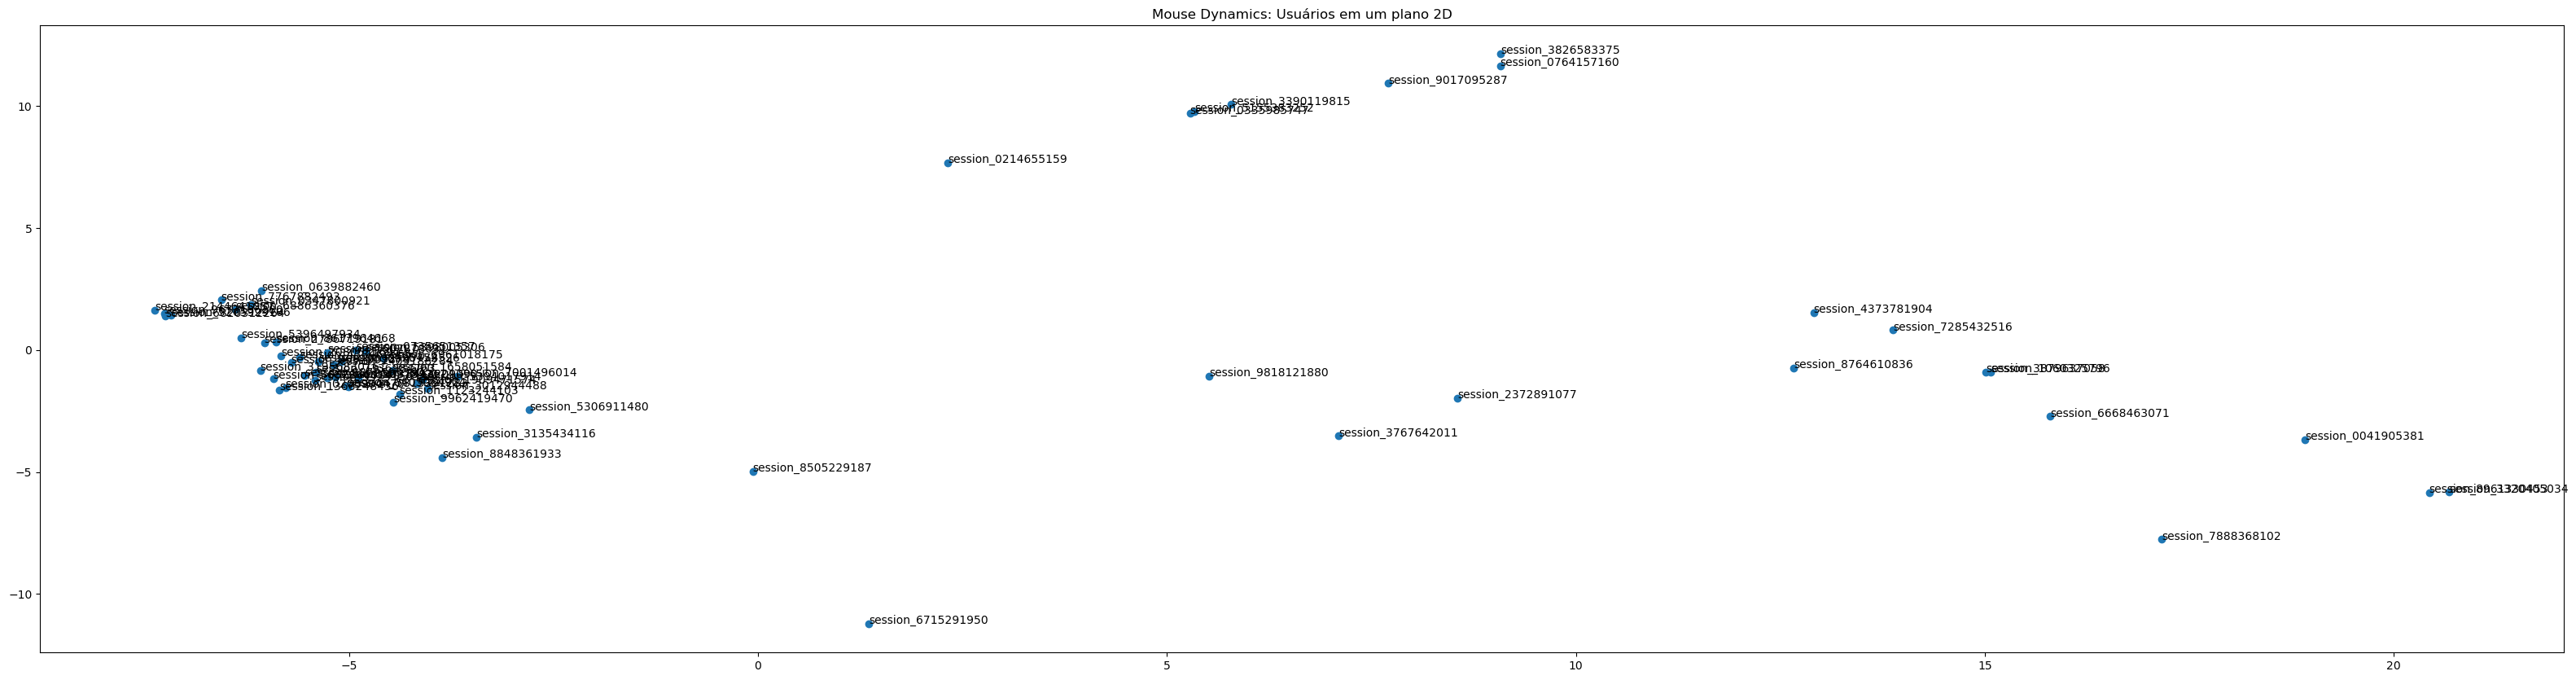

In [113]:
fig, ax = plt.subplots()

fig.set_size_inches(40, 10)
ax.scatter(groups_2d[:,0],groups_2d[:,1])
ax.set_title("Mouse Dynamics: Usuários em um plano 2D")

for i, txt in enumerate(df_session_grouped_mean.index):
    ax.annotate(txt, (groups_2d[i,0],groups_2d[i,1]))

In [114]:
cluster_vals=range(1,11)
distortions=[]
for c in cluster_vals:
    kmeans=KMeans(n_clusters=c)
    cluster_index=kmeans.fit_predict(df_session_grouped_mean)
    distortions.append(sum(np.min(cdist(df_session_grouped_mean, kmeans.cluster_centers_, 'euclidean'), axis=1))/df_session_grouped_mean.shape[0])


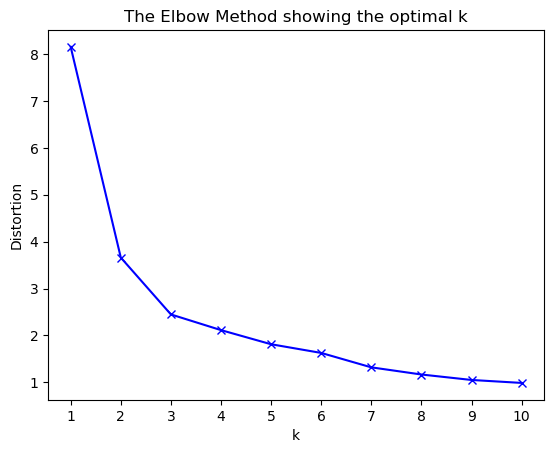

In [115]:
plt.xticks(cluster_vals)
plt.plot(cluster_vals,distortions,'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

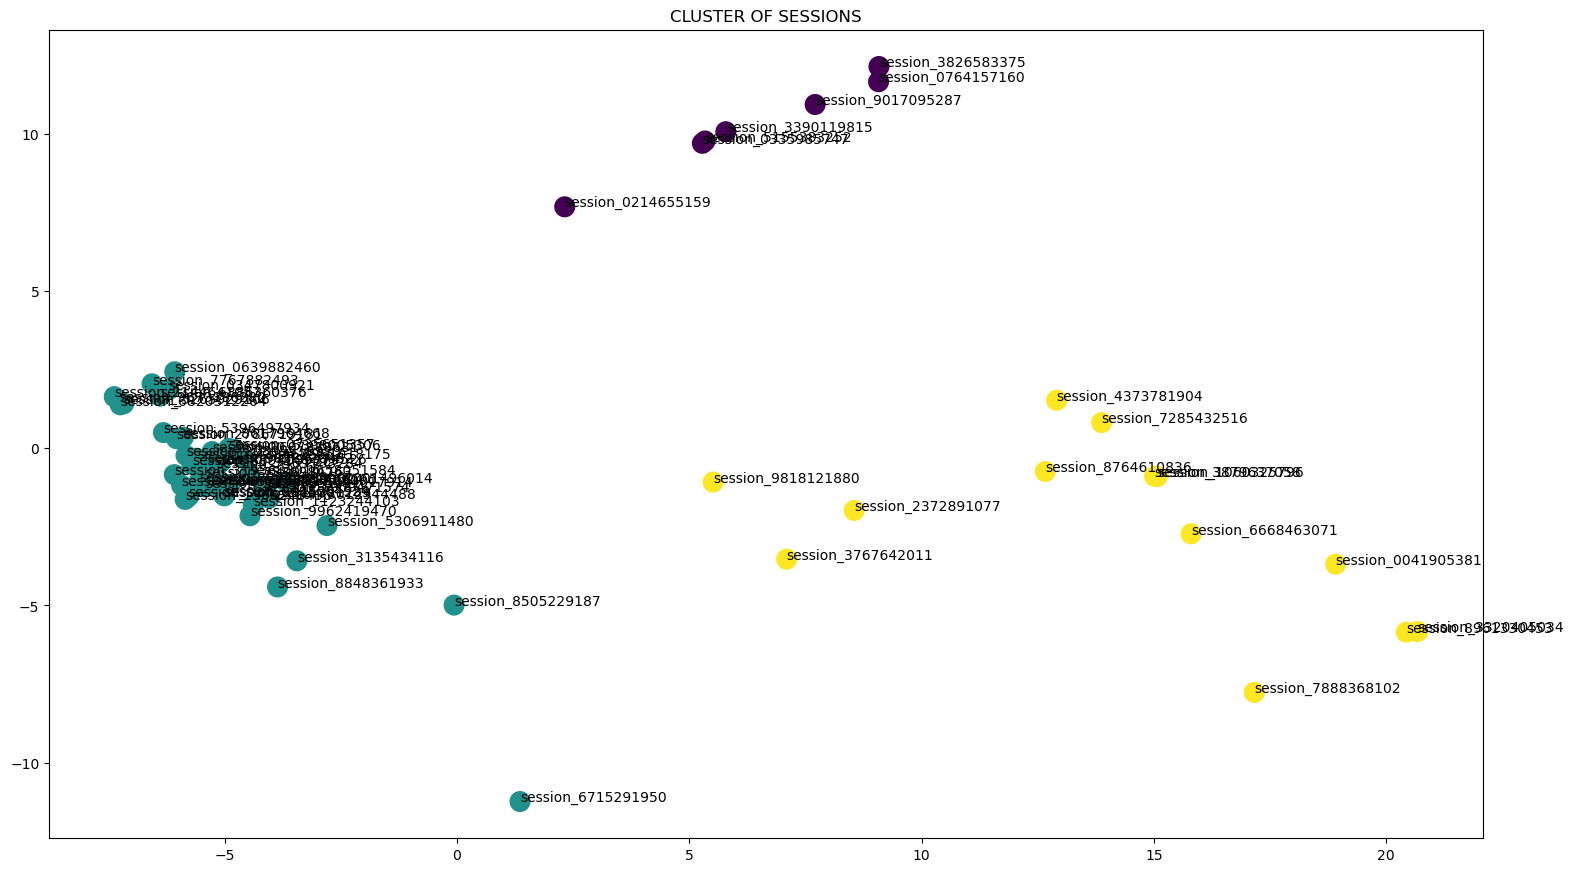

In [117]:
kmeans=KMeans(n_clusters=3)
cluster_index=kmeans.fit_predict(df_session_grouped_mean)

fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.scatter(groups_2d[:,0],groups_2d[:,1],c=cluster_index,marker='o',s=200)
ax.set_title("CLUSTER OF SESSIONS")
for i, txt in enumerate(df_session_grouped_mean.index):
    ax.annotate(txt, (groups_2d[i,0],groups_2d[i,1]))

In [134]:
df_session_grouped_mean

,veloc,dveloc,theta,dtheta/dt,accel
profile,,,,,
session_0041905381,0.516223,-4.418664e-06,-0.005632,24.091143,18.916515
session_0205904470,0.327657,-4.609612e-07,-0.017663,4.618533,3.591403
session_0214655159,0.009833,-2.172460e-07,0.051264,16.436533,0.324270
session_0335985747,0.007843,4.272151e-08,0.107958,20.021550,0.257412
session_0347800921,0.014185,-2.096333e-09,-0.000088,6.122323,0.521382
session_0405064924,0.384177,-1.689258e-05,0.074698,5.272458,3.957146
session_0595774526,0.301016,-2.901517e-05,0.080653,5.768533,3.071567
session_0639882460,0.007157,-1.115587e-08,-0.037305,6.540859,0.117396
session_0735651357,0.301910,1.796962e-06,0.077882,6.179212,2.785662


In [141]:
df_session_grouped_mean2 = df_session_grouped_mean2.reset_index()

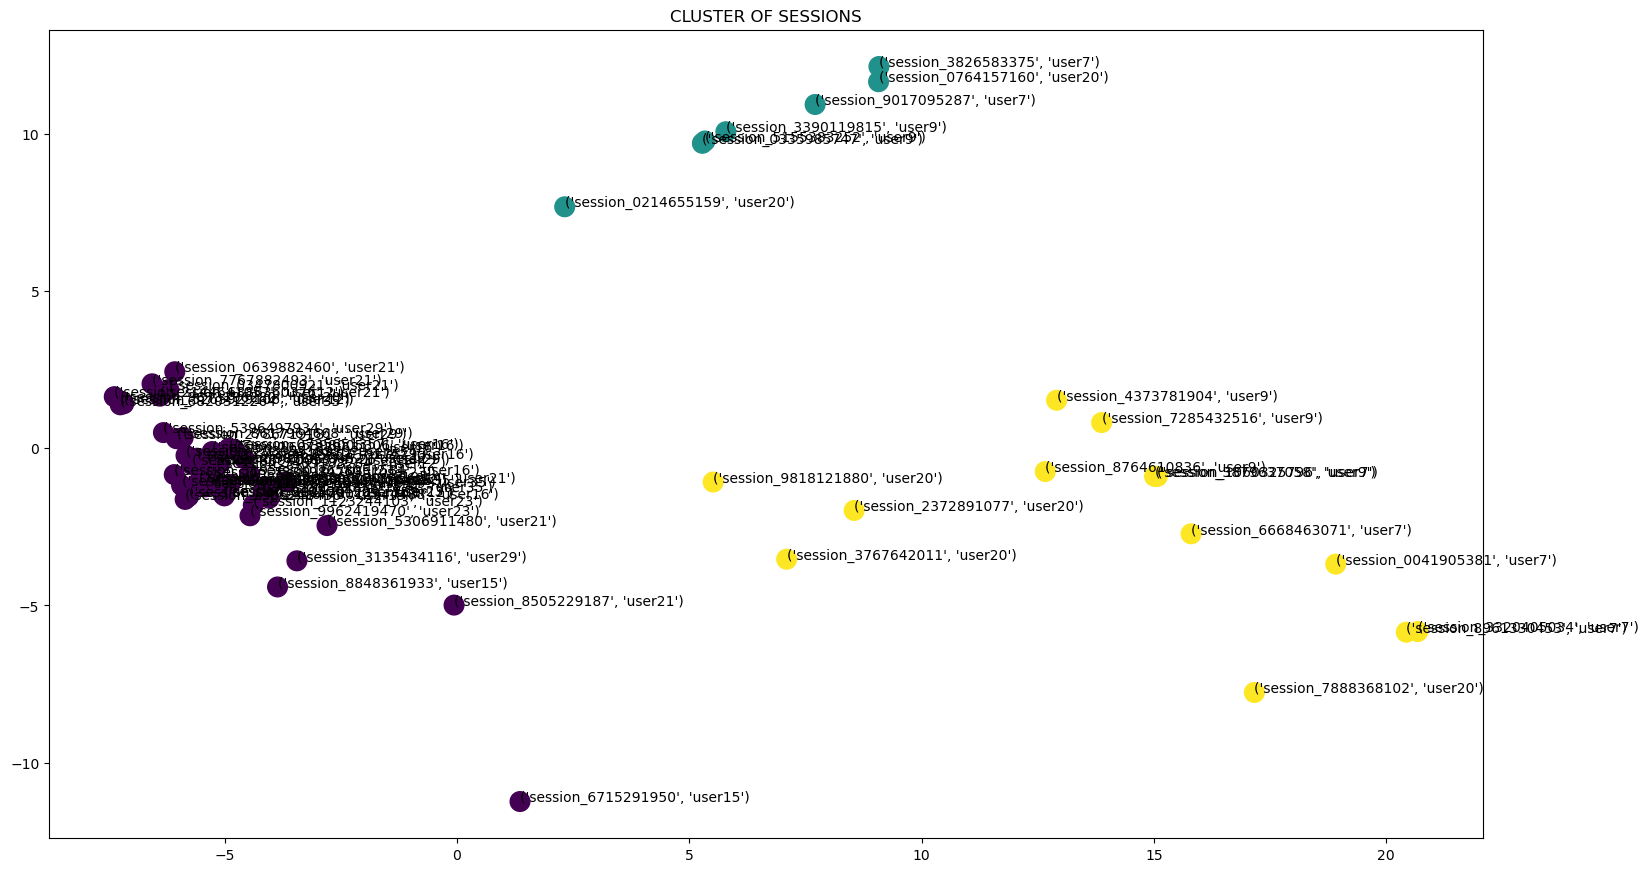

In [147]:
kmeans=KMeans(n_clusters=3)
cluster_index=kmeans.fit_predict(df_session_grouped_mean2)

fig, ax = plt.subplots()

fig.set_size_inches(18.5, 10.5)
ax.scatter(groups_2d[:,0],groups_2d[:,1],c=cluster_index,marker='o',s=200)
ax.set_title("CLUSTER OF SESSIONS")
for i, txt in enumerate(df_session_grouped_mean2.index):
    ax.annotate(txt, (groups_2d[i,0],groups_2d[i,1]))

In [126]:
df_session[df_session['user'] == 'user12'].profile.value_counts()

session_5815391283    46198
session_9031593624    38217
session_5265929106    30239
session_8872593360    29864
session_9838420452    28326
session_2144641057    27539
session_7409188284    23092
Name: profile, dtype: int64

array([[<AxesSubplot: title={'center': 'index'}>,
        <AxesSubplot: title={'center': 'record timestamp'}>,
        <AxesSubplot: title={'center': 'client timestamp'}>,
        <AxesSubplot: title={'center': 'x'}>],
       [<AxesSubplot: title={'center': 'y'}>,
        <AxesSubplot: title={'center': 'dx'}>,
        <AxesSubplot: title={'center': 'dy'}>,
        <AxesSubplot: title={'center': 'dt'}>],
       [<AxesSubplot: title={'center': 'dx/dt'}>,
        <AxesSubplot: title={'center': 'dy/dt'}>,
        <AxesSubplot: title={'center': 'veloc'}>,
        <AxesSubplot: title={'center': 'theta'}>],
       [<AxesSubplot: title={'center': 'dveloc'}>,
        <AxesSubplot: title={'center': 'dtheta'}>,
        <AxesSubplot: title={'center': 'accel'}>,
        <AxesSubplot: title={'center': 'dtheta/dt'}>]], dtype=object)

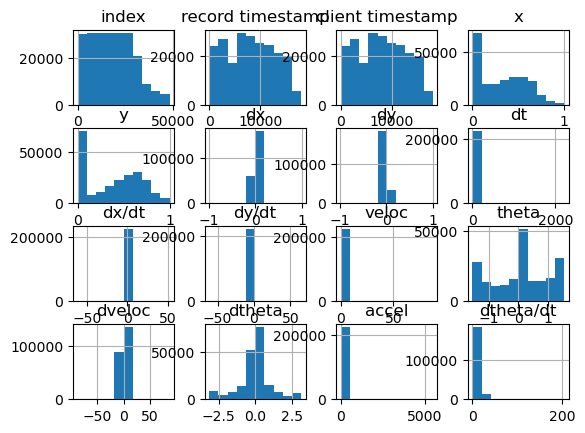

In [125]:
df_session[df_session['user'] == 'user12'].hist()